# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import pimmslearn
import pimmslearn.analyzers
import pimmslearn.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
pimmslearn.plotting.make_large_descriptors(fontsize)


logger = pimmslearn.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "RF"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = pimmslearn.nb.get_params(args, globals=globals())
args = pimmslearn.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = pimmslearn.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'RF',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = pimmslearn.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

pimmslearn.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


pimmslearn.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


pimmslearn.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups                     
Sample_114  P31150                                16.036
Sample_205  P52799                                16.587
Sample_080  A0A0A0MSQ0;P13797;P13797-2;P13797-3   13.173
Sample_070  P01780                                20.426
Sample_165  P09871                                20.863
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = pimmslearn.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[pimmslearn.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = pimmslearn.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by RF: runs/alzheimer_study/preds/pred_real_na_RF.csv


Sample ID   protein groups          
Sample_174  Q9UMX0;Q9UMX0-2;Q9UMX0-4   13.185
Sample_171  Q14165                     16.390
Sample_173  A0A087WSY4                 15.945
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 12.703
            A0A075B6Q5                 13.907
            A0A075B6R2                 12.956
            A0A075B6S5                 13.251
            A0A087WSY4                 15.436
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   13.250
            Q9UI40;Q9UI40-2            13.809
            Q9UIW2                     11.209
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   12.609
            Q9UP79                     12.220
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,13.969,15.050,16.842,19.863,15.657,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.443,19.067,...,15.528,15.576,14.024,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,15.667,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,15.663,17.705,17.039,16.062,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.350,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.181,15.345,17.084,18.708,14.249,19.433,12.381,11.354
Sample_207,15.739,16.877,15.469,16.898,15.266,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6K4,...,O14793,O95479;R4GMU1,P01282;P01282-2,P10619;P10619-2;X6R5C5;X6R8A1,P21810,Q14956;Q14956-2,Q6ZMP0;Q6ZMP0-2,Q9HBW1,Q9NY15,P17050
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,16.148,...,11.595,14.370,13.516,12.147,14.240,11.901,12.640,12.421,13.382,12.752
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,11.640,19.067,16.127,...,12.799,11.259,10.798,13.379,12.366,12.532,12.356,12.547,12.090,13.443
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,15.387,...,12.413,13.371,13.850,12.985,12.464,13.706,12.288,12.982,12.872,12.409
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,16.565,...,12.879,11.857,12.025,14.050,12.201,13.708,13.767,13.463,13.171,13.356
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,16.418,...,13.871,14.050,13.440,12.625,13.693,12.882,12.938,13.251,12.564,13.632
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,11.609,16.413,19.102,15.350,...,14.269,14.064,16.826,18.182,15.225,15.044,14.192,16.605,14.995,14.257
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,16.582,...,14.273,17.700,16.802,20.202,15.280,15.086,13.978,18.086,15.557,14.171
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,15.768,...,14.473,16.882,16.917,20.105,15.690,15.135,13.138,17.066,15.706,15.690


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 378.86it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  7.29it/s]

100%|██████████| 2/2 [00:00<00:00,  7.22it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  9.17it/s]

100%|██████████| 3/3 [00:00<00:00,  5.54it/s]

100%|██████████| 3/3 [00:00<00:00,  5.99it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.51it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  5.28it/s]

100%|██████████| 4/4 [00:00<00:00,  4.29it/s]

100%|██████████| 4/4 [00:00<00:00,  4.55it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  6.19it/s]

 60%|██████    | 3/5 [00:00<00:00,  4.24it/s]

 80%|████████  | 4/5 [00:00<00:00,  4.12it/s]

100%|██████████| 5/5 [00:01<00:00,  3.51it/s]

100%|██████████| 5/5 [00:01<00:00,  3.90it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  8.34it/s]

 50%|█████     | 3/6 [00:00<00:00,  5.75it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  5.07it/s]

 83%|████████▎ | 5/6 [00:00<00:00,  4.65it/s]

100%|██████████| 6/6 [00:01<00:00,  4.49it/s]

100%|██████████| 6/6 [00:01<00:00,  4.94it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  8.14it/s]

 43%|████▎     | 3/7 [00:00<00:00,  5.22it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  4.40it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  3.66it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  3.90it/s]

100%|██████████| 7/7 [00:01<00:00,  4.07it/s]

100%|██████████| 7/7 [00:01<00:00,  4.30it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  5.17it/s]

 38%|███▊      | 3/8 [00:00<00:01,  4.37it/s]

 50%|█████     | 4/8 [00:01<00:01,  3.54it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  3.38it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.29it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  3.12it/s]

100%|██████████| 8/8 [00:02<00:00,  2.66it/s]

100%|██████████| 8/8 [00:02<00:00,  3.16it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  5.38it/s]

 33%|███▎      | 3/9 [00:00<00:01,  3.64it/s]

 44%|████▍     | 4/9 [00:01<00:01,  2.89it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  2.60it/s]

 67%|██████▋   | 6/9 [00:02<00:01,  2.54it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.37it/s]

 89%|████████▉ | 8/9 [00:03<00:00,  2.36it/s]

100%|██████████| 9/9 [00:03<00:00,  2.52it/s]

100%|██████████| 9/9 [00:03<00:00,  2.68it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  6.22it/s]

 30%|███       | 3/10 [00:00<00:01,  4.68it/s]

 40%|████      | 4/10 [00:00<00:01,  4.42it/s]

 50%|█████     | 5/10 [00:01<00:01,  4.48it/s]

 60%|██████    | 6/10 [00:01<00:00,  4.64it/s]

 70%|███████   | 7/10 [00:01<00:00,  4.66it/s]

 80%|████████  | 8/10 [00:01<00:00,  4.46it/s]

 90%|█████████ | 9/10 [00:01<00:00,  4.60it/s]

100%|██████████| 10/10 [00:02<00:00,  4.57it/s]

100%|██████████| 10/10 [00:02<00:00,  4.63it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  7.46it/s]

 27%|██▋       | 3/11 [00:00<00:01,  6.07it/s]

 36%|███▋      | 4/11 [00:00<00:01,  5.52it/s]

 45%|████▌     | 5/11 [00:00<00:01,  5.54it/s]

 55%|█████▍    | 6/11 [00:01<00:00,  5.48it/s]

 64%|██████▎   | 7/11 [00:01<00:00,  5.28it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  5.29it/s]

 82%|████████▏ | 9/11 [00:01<00:00,  5.57it/s]

 91%|█████████ | 10/11 [00:01<00:00,  5.93it/s]

100%|██████████| 11/11 [00:01<00:00,  6.21it/s]

100%|██████████| 11/11 [00:01<00:00,  5.82it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  8.29it/s]

 25%|██▌       | 3/12 [00:00<00:01,  5.99it/s]

 33%|███▎      | 4/12 [00:00<00:01,  5.28it/s]

 42%|████▏     | 5/12 [00:00<00:01,  4.76it/s]

 50%|█████     | 6/12 [00:01<00:01,  4.58it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  4.27it/s]

 67%|██████▋   | 8/12 [00:01<00:00,  4.30it/s]

 75%|███████▌  | 9/12 [00:01<00:00,  4.25it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  3.84it/s]

 92%|█████████▏| 11/12 [00:02<00:00,  3.92it/s]

100%|██████████| 12/12 [00:02<00:00,  3.90it/s]

100%|██████████| 12/12 [00:02<00:00,  4.37it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  7.59it/s]

 23%|██▎       | 3/13 [00:00<00:01,  5.23it/s]

 31%|███       | 4/13 [00:00<00:01,  5.58it/s]

 38%|███▊      | 5/13 [00:00<00:01,  4.91it/s]

 46%|████▌     | 6/13 [00:01<00:01,  4.70it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  4.44it/s]

 62%|██████▏   | 8/13 [00:01<00:01,  4.54it/s]

 69%|██████▉   | 9/13 [00:01<00:00,  4.16it/s]

 77%|███████▋  | 10/13 [00:02<00:00,  4.01it/s]

 85%|████████▍ | 11/13 [00:02<00:00,  3.98it/s]

 92%|█████████▏| 12/13 [00:02<00:00,  4.18it/s]

100%|██████████| 13/13 [00:02<00:00,  4.34it/s]

100%|██████████| 13/13 [00:02<00:00,  4.53it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  6.07it/s]

 21%|██▏       | 3/14 [00:00<00:02,  4.21it/s]

 29%|██▊       | 4/14 [00:00<00:02,  3.77it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.41it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.21it/s]

 50%|█████     | 7/14 [00:01<00:02,  3.41it/s]

 57%|█████▋    | 8/14 [00:02<00:01,  3.70it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.65it/s]

 71%|███████▏  | 10/14 [00:02<00:01,  3.92it/s]

 79%|███████▊  | 11/14 [00:02<00:00,  4.00it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  4.04it/s]

 93%|█████████▎| 13/14 [00:03<00:00,  4.14it/s]

100%|██████████| 14/14 [00:03<00:00,  4.16it/s]

100%|██████████| 14/14 [00:03<00:00,  3.90it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01,  9.13it/s]

 20%|██        | 3/15 [00:00<00:02,  5.95it/s]

 27%|██▋       | 4/15 [00:00<00:02,  5.20it/s]

 33%|███▎      | 5/15 [00:00<00:02,  4.89it/s]

 40%|████      | 6/15 [00:01<00:02,  4.48it/s]

 47%|████▋     | 7/15 [00:01<00:01,  4.05it/s]

 53%|█████▎    | 8/15 [00:01<00:01,  3.69it/s]

 60%|██████    | 9/15 [00:02<00:01,  3.11it/s]

 67%|██████▋   | 10/15 [00:02<00:01,  2.79it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  2.82it/s]

 80%|████████  | 12/15 [00:03<00:00,  3.05it/s]

 87%|████████▋ | 13/15 [00:03<00:00,  3.29it/s]

 93%|█████████▎| 14/15 [00:03<00:00,  3.51it/s]

100%|██████████| 15/15 [00:04<00:00,  3.69it/s]

100%|██████████| 15/15 [00:04<00:00,  3.72it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.004      0.044 0.018          0.751 0.365       0.121   
2             0.004 0.003      0.045 0.017          0.701 0.126       0.631   
3             0.005 0.004      0.056 0.020          0.691 0.111       0.617   
4             0.004 0.003      0.039 0.009          0.707 0.109       0.625   
5             0.005 0.003      0.045 0.013          0.693 0.095       0.669   
6             0.005 0.004      0.055 0.018          0.815 0.083       0.822   
7             0.004 0.002      0.044 0.017          0.809 0.085       0.824   
8             0.006 0.006      0.062 0.031          0.814 0.087       0.824   
9             0.007 0.008      0.062 0.027          0.823 0.083       0.827   
10            0.003 0.000      0.034 0.006          0.822 0.086       0.822   
11            0.003 0.002      0.027 0.010          0.807 0.081       0.821   
12            0.003 0.000      0.033 0.003          0.811 0.091       0.822   
13            0.005 0.004      0.044 0.019          0.834 0.085       0.819   
14            0.004 0.003      0.047 0.019          0.822 0.088       0.814   
15            0.005 0.004      0.041 0.014          0.818 0.086       0.812   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.089   0.201 0.135                  0.553 0.043        0.850   
2          0.127   0.654 0.093                  0.710 0.075        0.787   
3          0.131   0.641 0.092                  0.702 0.071        0.785   
4          0.116   0.656 0.087                  0.714 0.067        0.807   
5          0.118   0.674 0.081                  0.723 0.066        0.811   
6          0.099   0.814 0.066                  0.841 0.056        0.903   
7          0.103   0.812 0.072                  0.840 0.061        0.901   
8          0.102   0.815 0.072                  0.842 0.060        0.901   
9          0.111   0.820 0.074                  0.847 0.062        0.909   
10         0.112   0.817 0.076                  0.845 0.064        0.908   
11         0.107   0.809 0.070                  0.837 0.059        0.905   
12         0.101   0.812 0.072                  0.839 0.062        0.906   
13         0.104   0.822 0.074                  0.848 0.063        0.913   
14         0.103   0.814 0.075                  0.841 0.064        0.912   
15         0.098   0.811 0.074                  0.839 0.062        0.911   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.064                  0.822 0.089        210.000 0.000  
2          0.074                  0.729 0.093        210.000 0.000  
3          0.075                  0.716 0.095        210.000 0.000  
4          0.071                  0.756 0.099        210.000 0.000  
5          0.066                  0.762 0.094        210.000 0.000  
6          0.049                  0.878 0.063        210.000 0.000  
7          0.050                  0.875 0.064        210.000 0.000  
8          0.050                  0.879 0.062        210.000 0.000  
9          0.050                  0.897 0.053        210.000 0.000  
10         0.051                  0.895 0.054        210.000 0.000  
11         0.051                  0.892 0.054        210.000 0.000  
12         0.052                  0.896 0.052        210.000 0.000  
13         0.051                  0.904 0.049        210.000 0.000  
14         0.050                  0.903 0.049        210.000 0.000  
15         0.051                  0.901 0.049 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 528.05it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  5.96it/s]

100%|██████████| 2/2 [00:00<00:00,  5.94it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  6.28it/s]

100%|██████████| 3/3 [00:00<00:00,  4.58it/s]

100%|██████████| 3/3 [00:00<00:00,  4.82it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.79it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  4.49it/s]

100%|██████████| 4/4 [00:00<00:00,  3.91it/s]

100%|██████████| 4/4 [00:00<00:00,  4.21it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  4.81it/s]

 60%|██████    | 3/5 [00:00<00:00,  3.13it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.59it/s]

100%|██████████| 5/5 [00:01<00:00,  2.55it/s]

100%|██████████| 5/5 [00:01<00:00,  2.79it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  4.44it/s]

 50%|█████     | 3/6 [00:00<00:01,  2.94it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.73it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  2.54it/s]

100%|██████████| 6/6 [00:02<00:00,  2.70it/s]

100%|██████████| 6/6 [00:02<00:00,  2.80it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  7.64it/s]

 43%|████▎     | 3/7 [00:00<00:00,  5.40it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  4.86it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  4.46it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  3.43it/s]

100%|██████████| 7/7 [00:01<00:00,  3.08it/s]

100%|██████████| 7/7 [00:01<00:00,  3.77it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00, 10.11it/s]

 50%|█████     | 4/8 [00:00<00:00,  5.71it/s]

 62%|██████▎   | 5/8 [00:00<00:00,  4.86it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.89it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  3.46it/s]

100%|██████████| 8/8 [00:02<00:00,  3.15it/s]

100%|██████████| 8/8 [00:02<00:00,  3.86it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00,  7.55it/s]

 33%|███▎      | 3/9 [00:00<00:01,  5.83it/s]

 44%|████▍     | 4/9 [00:00<00:00,  5.00it/s]

 56%|█████▌    | 5/9 [00:00<00:00,  4.55it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  4.34it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  3.44it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  3.00it/s]

100%|██████████| 9/9 [00:02<00:00,  2.88it/s]

100%|██████████| 9/9 [00:02<00:00,  3.64it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  7.76it/s]

 30%|███       | 3/10 [00:00<00:01,  5.77it/s]

 40%|████      | 4/10 [00:00<00:01,  4.66it/s]

 50%|█████     | 5/10 [00:01<00:01,  4.30it/s]

 60%|██████    | 6/10 [00:01<00:00,  4.06it/s]

 70%|███████   | 7/10 [00:01<00:00,  3.87it/s]

 80%|████████  | 8/10 [00:01<00:00,  3.82it/s]

 90%|█████████ | 9/10 [00:02<00:00,  3.34it/s]

100%|██████████| 10/10 [00:02<00:00,  3.03it/s]

100%|██████████| 10/10 [00:02<00:00,  3.75it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  8.39it/s]

 27%|██▋       | 3/11 [00:00<00:01,  6.26it/s]

 36%|███▋      | 4/11 [00:00<00:01,  5.91it/s]

 45%|████▌     | 5/11 [00:00<00:01,  5.94it/s]

 55%|█████▍    | 6/11 [00:00<00:00,  6.10it/s]

 64%|██████▎   | 7/11 [00:01<00:00,  5.90it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  4.51it/s]

 82%|████████▏ | 9/11 [00:01<00:00,  3.84it/s]

 91%|█████████ | 10/11 [00:02<00:00,  3.59it/s]

100%|██████████| 11/11 [00:02<00:00,  3.33it/s]

100%|██████████| 11/11 [00:02<00:00,  4.41it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  7.96it/s]

 25%|██▌       | 3/12 [00:00<00:01,  5.78it/s]

 33%|███▎      | 4/12 [00:00<00:01,  5.04it/s]

 42%|████▏     | 5/12 [00:00<00:01,  4.88it/s]

 50%|█████     | 6/12 [00:01<00:01,  4.53it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  4.34it/s]

 67%|██████▋   | 8/12 [00:01<00:00,  4.24it/s]

 75%|███████▌  | 9/12 [00:01<00:00,  4.20it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  3.36it/s]

 92%|█████████▏| 11/12 [00:02<00:00,  2.99it/s]

100%|██████████| 12/12 [00:03<00:00,  2.83it/s]

100%|██████████| 12/12 [00:03<00:00,  3.76it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  7.59it/s]

 23%|██▎       | 3/13 [00:00<00:01,  5.34it/s]

 31%|███       | 4/13 [00:00<00:01,  4.61it/s]

 38%|███▊      | 5/13 [00:01<00:01,  4.44it/s]

 46%|████▌     | 6/13 [00:01<00:01,  4.19it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  4.22it/s]

 62%|██████▏   | 8/13 [00:01<00:01,  4.21it/s]

 69%|██████▉   | 9/13 [00:02<00:00,  4.17it/s]

 77%|███████▋  | 10/13 [00:02<00:00,  4.09it/s]

 85%|████████▍ | 11/13 [00:02<00:00,  4.04it/s]

 92%|█████████▏| 12/13 [00:02<00:00,  4.10it/s]

100%|██████████| 13/13 [00:03<00:00,  3.34it/s]

100%|██████████| 13/13 [00:03<00:00,  4.07it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  6.47it/s]

 21%|██▏       | 3/14 [00:00<00:02,  3.90it/s]

 29%|██▊       | 4/14 [00:01<00:02,  3.36it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.33it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.61it/s]

 50%|█████     | 7/14 [00:01<00:01,  3.58it/s]

 57%|█████▋    | 8/14 [00:02<00:01,  3.82it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.91it/s]

 71%|███████▏  | 10/14 [00:02<00:01,  3.98it/s]

 79%|███████▊  | 11/14 [00:02<00:00,  4.06it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  4.05it/s]

 93%|█████████▎| 13/14 [00:03<00:00,  3.89it/s]

100%|██████████| 14/14 [00:03<00:00,  3.82it/s]

100%|██████████| 14/14 [00:03<00:00,  3.85it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  5.12it/s]

 20%|██        | 3/15 [00:00<00:03,  3.55it/s]

 27%|██▋       | 4/15 [00:01<00:03,  2.95it/s]

 33%|███▎      | 5/15 [00:01<00:03,  2.86it/s]

 40%|████      | 6/15 [00:01<00:03,  2.90it/s]

 47%|████▋     | 7/15 [00:02<00:02,  2.96it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  3.01it/s]

 60%|██████    | 9/15 [00:02<00:01,  3.12it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  3.20it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  3.33it/s]

 80%|████████  | 12/15 [00:03<00:00,  3.59it/s]

 87%|████████▋ | 13/15 [00:03<00:00,  3.69it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  3.79it/s]

100%|██████████| 15/15 [00:04<00:00,  3.92it/s]

100%|██████████| 15/15 [00:04<00:00,  3.41it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.006 0.007      0.043 0.012          0.000 0.000       0.000   
2             0.003 0.000      0.037 0.005          0.759 0.102       0.606   
3             0.003 0.001      0.039 0.010          0.751 0.086       0.659   
4             0.005 0.004      0.042 0.014          0.753 0.088       0.658   
5             0.006 0.006      0.056 0.024          0.743 0.089       0.685   
6             0.005 0.005      0.042 0.015          0.753 0.094       0.697   
7             0.004 0.003      0.045 0.016          0.732 0.102       0.690   
8             0.004 0.002      0.041 0.014          0.729 0.112       0.694   
9             0.004 0.003      0.041 0.018          0.738 0.107       0.695   
10            0.006 0.005      0.047 0.019          0.773 0.095       0.764   
11            0.004 0.003      0.036 0.011          0.774 0.096       0.755   
12            0.004 0.002      0.040 0.014          0.785 0.094       0.761   
13            0.005 0.003      0.046 0.018          0.785 0.095       0.777   
14            0.005 0.004      0.049 0.017          0.787 0.087       0.773   
15            0.004 0.002      0.043 0.015          0.792 0.087       0.770   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.496 0.008        0.858   
2          0.129   0.664 0.094                  0.730 0.066        0.787   
3          0.115   0.696 0.084                  0.749 0.062        0.849   
4          0.122   0.696 0.089                  0.749 0.066        0.854   
5          0.120   0.707 0.086                  0.755 0.065        0.858   
6          0.108   0.718 0.079                  0.762 0.063        0.861   
7          0.124   0.704 0.093                  0.751 0.074        0.863   
8          0.135   0.705 0.105                  0.751 0.086        0.869   
9          0.134   0.710 0.102                  0.756 0.082        0.867   
10         0.114   0.763 0.084                  0.798 0.070        0.902   
11         0.118   0.759 0.085                  0.795 0.071        0.901   
12         0.119   0.766 0.084                  0.802 0.068        0.903   
13         0.111   0.775 0.081                  0.809 0.068        0.911   
14         0.112   0.775 0.080                  0.809 0.065        0.915   
15         0.109   0.776 0.079                  0.810 0.064        0.915   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.060                  0.824 0.086        210.000 0.000  
2          0.072                  0.732 0.092        210.000 0.000  
3          0.056                  0.817 0.071        210.000 0.000  
4          0.058                  0.821 0.071        210.000 0.000  
5          0.054                  0.829 0.064        210.000 0.000  
6          0.053                  0.837 0.063        210.000 0.000  
7          0.053                  0.838 0.064        210.000 0.000  
8          0.056                  0.840 0.068        210.000 0.000  
9          0.057                  0.836 0.069        210.000 0.000  
10         0.051                  0.876 0.062        210.000 0.000  
11         0.050                  0.874 0.060        210.000 0.000  
12         0.049                  0.879 0.057        210.000 0.000  
13         0.049                  0.889 0.058        210.000 0.000  
14         0.046                  0.894 0.055        210.000 0.000  
15         0.046                  0.894 0.056 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 1063.19it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 29.91it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 23.02it/s]

100%|██████████| 3/3 [00:00<00:00, 22.62it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [00:00<00:00, 18.77it/s]

100%|██████████| 4/4 [00:00<00:00, 15.55it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:00<00:00, 22.18it/s]

100%|██████████| 5/5 [00:00<00:00, 17.34it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 50%|█████     | 3/6 [00:00<00:00, 21.07it/s]

100%|██████████| 6/6 [00:00<00:00, 15.60it/s]

100%|██████████| 6/6 [00:00<00:00, 16.13it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:00<00:00, 23.04it/s]

 86%|████████▌ | 6/7 [00:00<00:00, 15.98it/s]

100%|██████████| 7/7 [00:00<00:00, 16.00it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [00:00<00:00, 21.17it/s]

 75%|███████▌  | 6/8 [00:00<00:00, 15.58it/s]

100%|██████████| 8/8 [00:00<00:00, 14.58it/s]

100%|██████████| 8/8 [00:00<00:00, 15.17it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 33%|███▎      | 3/9 [00:00<00:00, 22.14it/s]

 67%|██████▋   | 6/9 [00:00<00:00, 17.93it/s]

 89%|████████▉ | 8/9 [00:00<00:00, 17.01it/s]

100%|██████████| 9/9 [00:00<00:00, 17.47it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 21.91it/s]

 60%|██████    | 6/10 [00:00<00:00, 14.92it/s]

 80%|████████  | 8/10 [00:00<00:00, 13.67it/s]

100%|██████████| 10/10 [00:00<00:00, 13.05it/s]

100%|██████████| 10/10 [00:00<00:00, 13.89it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 23.64it/s]

 55%|█████▍    | 6/11 [00:00<00:00, 17.58it/s]

 73%|███████▎  | 8/11 [00:00<00:00, 15.10it/s]

 91%|█████████ | 10/11 [00:00<00:00, 14.32it/s]

100%|██████████| 11/11 [00:00<00:00, 15.34it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 25%|██▌       | 3/12 [00:00<00:00, 22.49it/s]

 50%|█████     | 6/12 [00:00<00:00, 15.47it/s]

 67%|██████▋   | 8/12 [00:00<00:00, 15.16it/s]

 83%|████████▎ | 10/12 [00:00<00:00, 14.31it/s]

100%|██████████| 12/12 [00:00<00:00, 13.09it/s]

100%|██████████| 12/12 [00:00<00:00, 14.00it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 20.04it/s]

 46%|████▌     | 6/13 [00:00<00:00, 15.73it/s]

 62%|██████▏   | 8/13 [00:00<00:00, 14.78it/s]

 77%|███████▋  | 10/13 [00:00<00:00, 14.61it/s]

 92%|█████████▏| 12/13 [00:00<00:00, 14.35it/s]

100%|██████████| 13/13 [00:00<00:00, 14.88it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [00:00<00:00, 24.31it/s]

 43%|████▎     | 6/14 [00:00<00:00, 15.23it/s]

 57%|█████▋    | 8/14 [00:00<00:00, 15.98it/s]

 71%|███████▏  | 10/14 [00:00<00:00, 16.51it/s]

 86%|████████▌ | 12/14 [00:00<00:00, 16.16it/s]

100%|██████████| 14/14 [00:00<00:00, 16.68it/s]

100%|██████████| 14/14 [00:00<00:00, 16.64it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 20%|██        | 3/15 [00:00<00:00, 21.10it/s]

 40%|████      | 6/15 [00:00<00:00, 15.92it/s]

 53%|█████▎    | 8/15 [00:00<00:00, 13.88it/s]

 67%|██████▋   | 10/15 [00:00<00:00, 13.27it/s]

 80%|████████  | 12/15 [00:00<00:00, 13.58it/s]

 93%|█████████▎| 14/15 [00:00<00:00, 13.74it/s]

100%|██████████| 15/15 [00:01<00:00, 14.38it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.003 0.002      0.038 0.011          0.000 0.000       0.000   
2             0.004 0.003      0.053 0.018          0.664 0.283       0.148   
3             0.004 0.003      0.041 0.013          0.547 0.259       0.161   
4             0.004 0.003      0.046 0.017          0.526 0.249       0.168   
5             0.004 0.002      0.040 0.012          0.494 0.213       0.178   
6             0.004 0.003      0.046 0.017          0.505 0.201       0.180   
7             0.005 0.004      0.050 0.018          0.461 0.196       0.168   
8             0.004 0.003      0.040 0.011          0.687 0.102       0.558   
9             0.005 0.003      0.048 0.017          0.702 0.093       0.585   
10            0.004 0.001      0.040 0.012          0.691 0.095       0.598   
11            0.005 0.004      0.049 0.017          0.680 0.093       0.600   
12            0.004 0.000      0.036 0.004          0.675 0.094       0.595   
13            0.005 0.004      0.049 0.020          0.677 0.105       0.597   
14            0.007 0.006      0.079 0.017          0.673 0.098       0.597   
15            0.006 0.005      0.049 0.016          0.669 0.095       0.596   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.738   
2          0.084   0.228 0.110                  0.536 0.048        0.589   
3          0.089   0.235 0.110                  0.525 0.050        0.589   
4          0.087   0.241 0.104                  0.521 0.048        0.570   
5          0.087   0.252 0.110                  0.518 0.057        0.548   
6          0.074   0.255 0.091                  0.515 0.058        0.532   
7          0.075   0.237 0.092                  0.504 0.054        0.521   
8          0.116   0.608 0.092                  0.683 0.062        0.738   
9          0.119   0.630 0.089                  0.699 0.059        0.746   
10         0.120   0.634 0.090                  0.699 0.066        0.770   
11         0.122   0.631 0.092                  0.696 0.068        0.771   
12         0.120   0.626 0.089                  0.691 0.066        0.768   
13         0.130   0.626 0.099                  0.692 0.073        0.763   
14         0.124   0.626 0.094                  0.691 0.070        0.761   
15         0.123   0.624 0.094                  0.689 0.070        0.757   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.071                  0.690 0.088        210.000 0.000  
2          0.075                  0.550 0.081        210.000 0.000  
3          0.072                  0.547 0.076        210.000 0.000  
4          0.075                  0.525 0.079        210.000 0.000  
5          0.080                  0.514 0.077        210.000 0.000  
6          0.080                  0.505 0.073        210.000 0.000  
7          0.084                  0.495 0.073        210.000 0.000  
8          0.071                  0.708 0.083        210.000 0.000  
9          0.071                  0.713 0.082        210.000 0.000  
10         0.065                  0.730 0.079        210.000 0.000  
11         0.068                  0.733 0.082        210.000 0.000  
12         0.067                  0.727 0.082        210.000 0.000  
13         0.070                  0.729 0.082        210.000 0.000  
14         0.071                  0.727 0.082        210.000 0.000  
15         0.071                  0.722 0.083 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,9,5,14
score_time,8,5,14
test_precision,13,15,9
test_recall,9,13,11
test_f1,13,15,10
test_balanced_accuracy,13,15,10
test_roc_auc,13,15,11
test_average_precision,13,15,11
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_ald_full, fname)

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  5.42it/s]

 20%|██        | 3/15 [00:00<00:03,  3.67it/s]

 27%|██▋       | 4/15 [00:01<00:03,  3.06it/s]

 33%|███▎      | 5/15 [00:01<00:03,  2.73it/s]

 40%|████      | 6/15 [00:01<00:03,  2.80it/s]

 47%|████▋     | 7/15 [00:02<00:03,  2.65it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  2.47it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.59it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  2.65it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  2.77it/s]

 80%|████████  | 12/15 [00:04<00:01,  2.86it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  3.04it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  3.15it/s]

100%|██████████| 15/15 [00:05<00:00,  3.31it/s]

100%|██████████| 15/15 [00:05<00:00,  2.98it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 20.62it/s]

 55%|█████▍    | 6/11 [00:00<00:00, 15.68it/s]

 73%|███████▎  | 8/11 [00:00<00:00, 16.24it/s]

 91%|█████████ | 10/11 [00:00<00:00, 14.49it/s]

100%|██████████| 11/11 [00:00<00:00, 15.15it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  6.66it/s]

 23%|██▎       | 3/13 [00:00<00:02,  4.87it/s]

 31%|███       | 4/13 [00:00<00:01,  5.05it/s]

 38%|███▊      | 5/13 [00:01<00:01,  4.72it/s]

 46%|████▌     | 6/13 [00:01<00:01,  4.59it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  4.49it/s]

 62%|██████▏   | 8/13 [00:01<00:01,  3.91it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  3.55it/s]

 77%|███████▋  | 10/13 [00:02<00:00,  3.60it/s]

 85%|████████▍ | 11/13 [00:02<00:00,  3.31it/s]

 92%|█████████▏| 12/13 [00:03<00:00,  3.21it/s]

100%|██████████| 13/13 [00:03<00:00,  3.08it/s]

100%|██████████| 13/13 [00:03<00:00,  3.76it/s]

### ROC-AUC on test split

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve.pdf


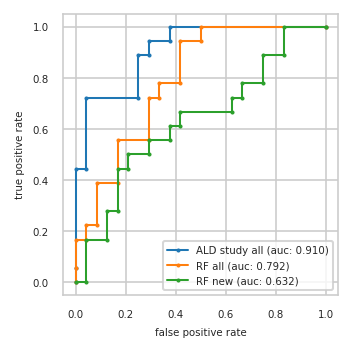

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       RF all       RF new      
             fpr   tpr    fpr   tpr    fpr   tpr
0          0.000 0.000  0.000 0.000  0.000 0.000
1          0.000 0.056  0.000 0.056  0.042 0.000
2          0.000 0.444  0.000 0.167  0.042 0.167
3          0.042 0.444  0.042 0.167  0.125 0.167
4          0.042 0.722  0.042 0.222  0.125 0.278
5          0.250 0.722  0.083 0.222  0.167 0.278
6          0.250 0.889  0.083 0.389  0.167 0.444
7          0.292 0.889  0.167 0.389  0.208 0.444
8          0.292 0.944  0.167 0.556  0.208 0.500
9          0.375 0.944  0.292 0.556  0.292 0.500
10         0.375 1.000  0.292 0.722  0.292 0.556
11         1.000 1.000  0.333 0.722  0.375 0.556
12           NaN   NaN  0.333 0.778  0.375 0.611
13           NaN   NaN  0.417 0.778  0.417 0.611
14           NaN   NaN  0.417 0.944  0.417 0.667
15           NaN   NaN  0.500 0.944  0.625 0.667
16           NaN   NaN  0.500 1.000  0.625 0.722
17           NaN   NaN  1.000 1.000  0.667 0.722
18           NaN   NaN    NaN   NaN  0.667 0.778
19           NaN   NaN    NaN   NaN  0.750 0.778
20           NaN   NaN    NaN   NaN  0.750 0.889
21           NaN   NaN    NaN   NaN  0.833 0.889
22           NaN   NaN    NaN   NaN  0.833 1.000
23           NaN   NaN    NaN   NaN  1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,RF all,RF new
rank,,,
0,P10636-2;P10636-6,P10636-2;P10636-6,Q14894
1,A0A0J9YX35,H0YMB1;Q96TC7;Q96TC7-2,E5RK69;E7EMC6;P08133;P08133-2
2,B8ZZ19;H0Y3U0;P20472,F5GWQ8;J3QKW8;Q15846,Q16799
3,P61981,P61981,P31321
4,A0A0A0MRJ7;P12259,Q9Y2T3;Q9Y2T3-3,Q9NUQ9
5,P04075,P04075,Q96GD0
6,P14174,P14174,A0A075B7B8
7,P00338;P00338-3,P63104,P51688
8,Q9Y2T3;Q9Y2T3-3,C9JF17;P05090,F8WBF9;Q5TH30;Q9UGV2;Q9UGV2-2;Q9UGV2-3


### Precision-Recall plot on test data

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve.pdf


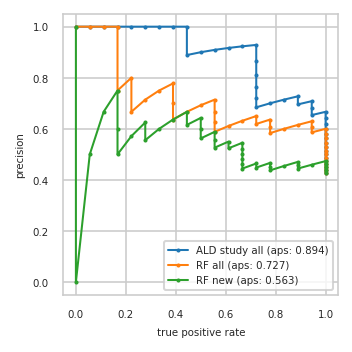

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all          RF all          RF new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.474 1.000     0.474 1.000
5          0.486 1.000     0.486 1.000     0.459 0.944
6          0.500 1.000     0.500 1.000     0.444 0.889
7          0.514 1.000     0.514 1.000     0.457 0.889
8          0.529 1.000     0.529 1.000     0.471 0.889
9          0.545 1.000     0.545 1.000     0.455 0.833
10         0.562 1.000     0.562 1.000     0.438 0.778
11         0.581 1.000     0.581 1.000     0.452 0.778
12         0.600 1.000     0.600 1.000     0.467 0.778
13         0.621 1.000     0.586 0.944     0.448 0.722
14         0.643 1.000     0.607 0.944     0.464 0.722
15         0.667 1.000     0.630 0.944     0.444 0.667
16         0.654 0.944     0.615 0.889     0.462 0.667
17         0.680 0.944     0.600 0.833     0.480 0.667
18         0.708 0.944     0.583 0.778     0.500 0.667
19         0.696 0.889     0.609 0.778     0.522 0.667
20         0.727 0.889     0.636 0.778     0.545 0.667
21         0.714 0.833     0.619 0.722     0.524 0.611
22         0.700 0.778     0.650 0.722     0.550 0.611
23         0.684 0.722     0.632 0.667     0.526 0.556
24         0.722 0.722     0.611 0.611     0.556 0.556
25         0.765 0.722     0.588 0.556     0.588 0.556
26         0.812 0.722     0.625 0.556     0.562 0.500
27         0.867 0.722     0.667 0.556     0.600 0.500
28         0.929 0.722     0.714 0.556     0.643 0.500
29         0.923 0.667     0.692 0.500     0.615 0.444
30         0.917 0.611     0.667 0.444     0.667 0.444
31         0.909 0.556     0.636 0.389     0.636 0.389
32         0.900 0.500     0.700 0.389     0.600 0.333
33         0.889 0.444     0.778 0.389     0.556 0.278
34         1.000 0.444     0.750 0.333     0.625 0.278
35         1.000 0.389     0.714 0.278     0.571 0.222
36         1.000 0.333     0.667 0.222     0.500 0.167
37         1.000 0.278     0.800 0.222     0.600 0.167
38         1.000 0.222     0.750 0.167     0.750 0.167
39         1.000 0.167     1.000 0.167     0.667 0.111
40         1.000 0.111     1.000 0.111     0.500 0.056
41         1.000 0.056     1.000 0.056     0.000 0.000
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve_train.pdf


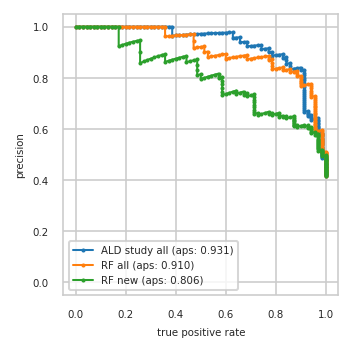

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve_train.pdf


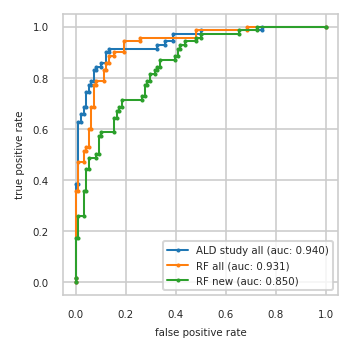

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_RF all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/results_RF all.pkl'),
 'results_RF new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/results_RF new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve_train.pdf')}